# Categorical Variables and Interactions

We continue our work with multiple linear regression by showing how to include categorical variables and interaction terms into your regression model.

## What we will accomplish

We will:
- Introduce a data set,
- Show how to incorporate categorical variables into multiple linear regression,
- Demonstrate one-hot encoding in python and
- Discuss interaction terms and how they affect your model.

In [1]:
## import some packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## A new data set

Let us start by loading in a new data set, `beer1.csv`. 

In [4]:
pwd

'/Users/macpc/Library/CloudStorage/OneDrive-FloridaStateUniversity/OnlineLearning/ErdosInstitute/data_science_bc/my_practice/04_regression_II/lecture_4'

In [23]:
## load the data
## note you may need to change the path if you
## are running Windows
beer = pd.read_csv("../../../Data/beer1.csv")

In [24]:
## Make the train test split
## ignore stratify for now, you will have a problem
## session question about it
beer_train, beer_test = train_test_split(beer.copy(), 
                                            shuffle=True,
                                            random_state=614,
                                            stratify=beer['Beer_Type'], # This preserves the fraction of each type in both train and test.
                                            test_size=.2)

In [25]:
beer_train.sample(5, random_state=440)

,IBU,ABV,Rating,Beer_Type
211,45,7.0,3.969,IPA
219,30,5.4,3.476,IPA
32,27,5.5,3.873,Stout
131,30,8.0,4.036,Stout
172,75,7.5,3.858,IPA


As we can see, this data set contains information on various beers. It includes the beer's `IBU` (international bitterness units), `ABV` (alcohol by volume), user `Rating` and the type of the beer. In this notebook we will focus on building models to predict the beer's `IBU`. It's reasonable to assume that `Rating` has no bearing on the `IBU` value for a particular beer, same for the name. So moving forward we will focus on the `ABV` and `Beer_Type` as potential features.

Let's look at any potential relationship between `IBU` and `ABV`.

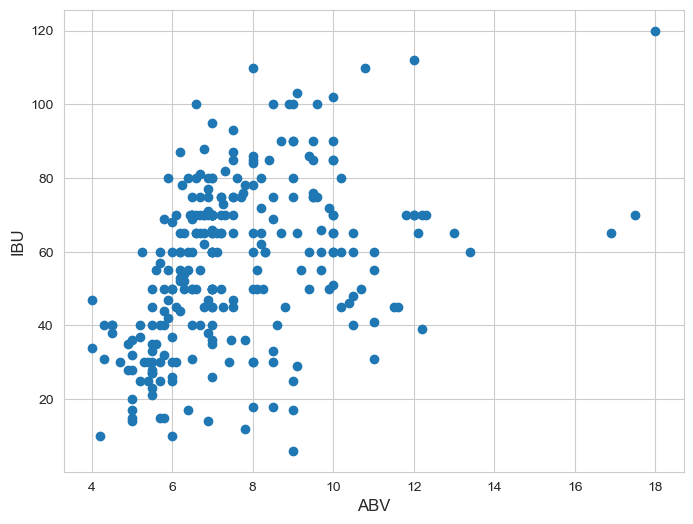

In [26]:
plt.figure(figsize=(8,6))

plt.scatter(beer_train.ABV,
               beer_train.IBU)

plt.xlabel("ABV", fontsize=12)
plt.ylabel("IBU", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

There appears to be positive linear relationship between `ABV` and `IBU`. Our first two models will thus be the simple baseline and a simple linear regression regressing `IBU` on `ABV`.

##### Baseline model

$$
\text{IBU} = E(\text{IBU}) + \epsilon
$$

##### Simple linear regression model

$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \epsilon
$$

## Categorical variables

Now let's investigate if `Beer_Type` seems to have any impact on `IBU`. One way to do this is to look at some plots.

A nice plot to use is `seaborn`'s `swarmplot`, <a href="https://seaborn.pydata.org/generated/seaborn.swarmplot.html">https://seaborn.pydata.org/generated/seaborn.swarmplot.html</a>. This plots each observation as a dot according to the value it has for the desired feature.

/Users/macpc/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/macpc/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


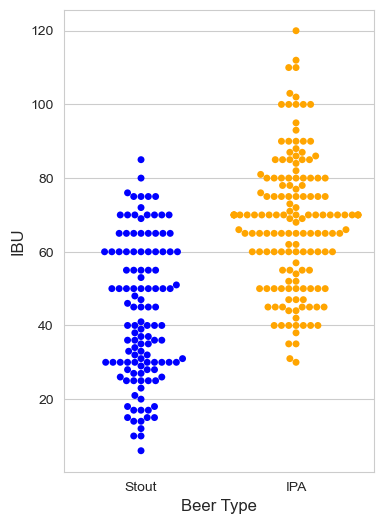

In [27]:
## Make a figure object
plt.figure(figsize=(4,6))

## Call swarmplot
## First put in the dataframe in data = 
## Then what you want on the x and y axis
## Finally, palette, an optional input, allows me to color the points
sns.swarmplot(data=beer_train,
               x = 'Beer_Type',
               y = 'IBU',
            hue='Beer_Type',
            palette=['blue', 'orange'],
            legend=False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Beer Type", fontsize=12)
plt.ylabel("IBU", fontsize=12)

plt.show()

If possible, we can also recreate the scatter plot from before, this time colored by category.

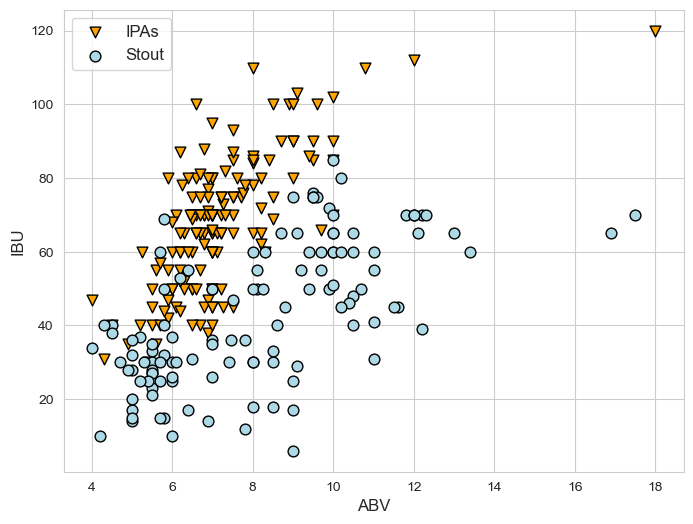

In [28]:
plt.figure(figsize=(8,6))

plt.scatter(beer_train.loc[beer_train.Beer_Type=='IPA'].ABV,
               beer_train.loc[beer_train.Beer_Type=='IPA'].IBU,
               label="IPAs",
               marker='v',
               s=60,
               edgecolor='black',
               c='orange')
plt.scatter(beer_train.loc[beer_train.Beer_Type=='Stout'].ABV,
               beer_train.loc[beer_train.Beer_Type=='Stout'].IBU,
               label="Stout",
               s=60,
               edgecolor='black',
               c='lightblue')

plt.xlabel("ABV", fontsize=12)
plt.ylabel("IBU", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.show()

In both plots there seems reason to believe that IPAs tent to have slightly higher IBUs than Stouts. Let's see how to encode this information to be used in multiple linear regression model.

### One-hot encoding

Currently our `Beer_Type` column is stored as a column of strings. This is great for human readability, but terrible for regression models, enter <i>one-hot encoding</i>.

One-hot encoding is when you take a categorical variable and represent it as a collection of new $0-1$ variables. Suppose you have a variable, $x$, with $k$ unique categories, then one-hot encoding is the process of creating $k-1$ indicator variables:

$$
1_j = \left\lbrace \begin{array}{l l} 1 & \text{if } x=j \\ 0 & \text{if } x \neq j\end{array} \right., \text{ for } j = 1, \dots, k-1.
$$

We only need $k-1$ of these variables because of the process of elimination. If all of the $1_j=0$, then that means that $x$ is not any of $1,\dots,k-1$ and thus it must be $k$.

#### In python

Let's now demonstrate how to do this in python. We will make an indicator for when a beer is a Stout, i.e.

$$
1_{\text{Stout}} = \left\lbrace \begin{array}{l l} 1 & \text{if the beer is a Stout}  \\ 0 & \text{Else} \end{array} \right..
$$

Since there are only two possible values we could do this by hand, but we will demonstrate a function that is useful for variables with more than two categories, `get_dummies`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html">https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html</a>.

In [ ]:
## Demonstrate it here


In [ ]:
## Store the variable in beer_train here
beer_train['Stout'] = 

In [ ]:
beer_train.head()

This new indicator variable allows us to fit a third model.

##### Stout model

$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \epsilon
$$

Let's think about what this model is actually doing before we fit it:

* When $\text{Stout} = 0$, we have $\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \epsilon$.
* When $\text{Stout} = 1$, we have $\text{IBU} = (\beta_0 + \beta_2) +  \beta_1 \text{ABV} + \epsilon$.  

In other words, our modeling assumption is that a beer being a stout gives us a fixed additional $\text{IBU}$ represented by $\beta_2$.  A plot of the model with $\text{Stout} = 0$ and $\text{Stout} = 1$ would give two parallel lines.

Let's quickly fit this model and plot it along with our training data. 

In [ ]:
## make the model object
stout_lr = LinearRegression(copy_X = True)

## Fit the model
stout_lr.fit(beer_train[['ABV', 'Stout']].values,
                beer_train['IBU'].values)

In [ ]:
## This code plots that model with the training data ##

plt.figure(figsize=(9,6))

plt.scatter(beer_train.loc[beer_train.Beer_Type=='IPA'].ABV,
               beer_train.loc[beer_train.Beer_Type=='IPA'].IBU,
               label="IPAs",
               marker='v',
               s=60,
               alpha=.5,
               edgecolor='black',
               c='orange')
plt.scatter(beer_train.loc[beer_train.Beer_Type=='Stout'].ABV,
               beer_train.loc[beer_train.Beer_Type=='Stout'].IBU,
               label="Stout",
               s=60,
               alpha=.5,
               edgecolor='black',
               c='lightblue')

xs_ipa = np.zeros((1000,2))
xs_ipa[:,0] = np.linspace(beer_train.ABV.min()-2,
                    beer_train.ABV.max()+2,1000)
ipa_line = stout_lr.predict(xs_ipa)

xs_stout = np.ones((1000,2))
xs_stout[:,0] = np.linspace(beer_train.ABV.min()-2,
                    beer_train.ABV.max()+2,1000)
stout_line = stout_lr.predict(xs_stout)


plt.plot(xs_ipa[:,0], ipa_line,
            '--', 
            c='orange',
            linewidth=1.5,
            label="Model Output for IPAs")
plt.plot(xs_stout[:,0], stout_line,
            '-', 
            c='blue',
            linewidth=1.5,
            label="Model Output for Stouts")


plt.xlabel("ABV", fontsize=12)
plt.ylabel("IBU", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.show()

## Interaction terms

As noted, the model we just fit produces lines with the same slope for IPAs and Stouts.

In order to impact the slope, we must add an <i>interaction term</i> between `ABV` and `Stout`.

Interaction terms are just a fancy way of saying we should multiply two variables. So here we want to multiply the `ABV` and the `Stout` column. This produces the following interaction model (our final model for this notebook):

##### Interaction Model

$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \beta_3 \text{ABV} \times \text{Stout} + \epsilon
$$

We can once again observe the differences for $\text{Stout} = 0$ vs $\text{Stout} = 1$.

When $\text{Stout}=0$ we have that:

$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \epsilon,
$$

however when $\text{Stout}=1$ we have:

$$
\text{IBU} = (\beta_0 + \beta_2) + (\beta_1 + \beta_3) \text{ABV} + \epsilon.
$$

In other words, $\beta_2$ is change in the intercept, and $\beta_3$ is the change in the slope, associated with stouts compared to IPAs.

Let's visualize this quickly.

In [ ]:
## Make the interaction term
beer_train['ABV_Stout'] = 

In [ ]:
## make the model object
interaction_lr = LinearRegression(copy_X = True)

## Fit the model
interaction_lr.fit(beer_train[['ABV', 'Stout', 'ABV_Stout']].values,
                        beer_train['IBU'].values)

In [ ]:
## This code plots that model with the training data ##

plt.figure(figsize=(9,6))

plt.scatter(beer_train.loc[beer_train.Beer_Type=='IPA'].ABV,
               beer_train.loc[beer_train.Beer_Type=='IPA'].IBU,
               label="IPAs",
               marker='v',
               s=60,
               alpha=.5,
               edgecolor='black',
               c='orange')
plt.scatter(beer_train.loc[beer_train.Beer_Type=='Stout'].ABV,
               beer_train.loc[beer_train.Beer_Type=='Stout'].IBU,
               label="Stout",
               s=60,
               alpha=.5,
               edgecolor='black',
               c='lightblue')
xs_ipa = np.zeros((1000,3))
xs_ipa[:,0] = np.linspace(beer_train.ABV.min()-2,
                    beer_train.ABV.max()+2,1000)
xs_ipa[:,2] = xs_ipa[:,0]*xs_ipa[:,1]
ipa_line = interaction_lr.predict(xs_ipa)

xs_stout = np.ones((1000,3))
xs_stout[:,0] = np.linspace(beer_train.ABV.min()-2,
                    beer_train.ABV.max()+2,1000)
xs_stout[:,2] = xs_stout[:,0]*xs_stout[:,1]
stout_line = interaction_lr.predict(xs_stout)


plt.plot(xs_ipa[:,0], ipa_line,
            '--', 
            c='orange',
            linewidth=1.5,
            label="Model Output for IPAs")
plt.plot(xs_stout[:,0], stout_line,
            '-', 
            c='blue',
            linewidth=1.5,
            label="Model Output for Stouts")


plt.xlabel("ABV", fontsize=12)
plt.ylabel("IBU", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.show()

This looks like a better fit on the training data. However we should be cautious:  it is a fact that adding more regressors **always** decreases the MSE on the training data.

So let's use cross-validation to see which of our four proposed models generalizes the best to unseen data.

### Comparing all four models

In [ ]:
## import KFold.  Note that StratifiedKFold would also be an option here, but I don't want to introduce too many new things at once.

from sklearn.model_selection import KFold

## import mean_squared_error
from sklearn.metrics import mean_squared_error as mse

In [ ]:
## Make the KFold object.
kfold = KFold(n_splits=5,
                 shuffle=True,
                 random_state=431)

In [ ]:
mses = np.zeros((4, 5))

## This will keep track of the split we are on
i = 0

for train_index, test_index in kfold.split(beer_train):
    beer_tt = beer_train.iloc[train_index]
    beer_ho = beer_train.iloc[test_index]
    
    ## baseline model
    pred_baseline = beer_tt.IBU.mean()*np.ones(len(beer_ho))
    
    ## SLR model
    slr = LinearRegression(copy_X=True)
    slr.fit(beer_tt.ABV.values.reshape(-1,1),
               beer_tt.IBU.values)
    pred_slr = slr.predict(beer_ho.ABV.values.reshape(-1,1))
    
    
    ## STOUT Model
    stout_model = LinearRegression(copy_X=True)
    stout_model.fit(beer_tt[['ABV', 'Stout']].values,
                 beer_tt.IBU.values)
    pred_stout = stout_model.predict(beer_ho[['ABV', 'Stout']].values)
    
    ## Interaction Model
    interact_model = LinearRegression(copy_X=True)
    interact_model.fit(beer_tt[['ABV', 'Stout', 'ABV_Stout']].values,
                       beer_tt.IBU.values)
    pred_interact = interact_model.predict(beer_ho[['ABV', 'Stout', 'ABV_Stout']].values)
    
    ### record MSEs ###
    mses[0,i] = mse(beer_ho.IBU.values, pred_baseline)
    mses[1,i] = mse(beer_ho.IBU.values, pred_slr)
    mses[2,i] = mse(beer_ho.IBU.values, pred_stout)
    mses[3,i] = mse(beer_ho.IBU.values, pred_interact)

    ## increase the counter
    i = i + 1

In [ ]:
##### Print the results
print("The average cross-validation mse for the baseline model is",
                      np.round(np.mean(mses, axis=1)[0],4))
print("The average cross-validation mse for the simple linear regression model is",
                      np.round(np.mean(mses, axis=1)[1],4))
print("The average cross-validation mse for the Stout model is",
                      np.round(np.mean(mses, axis=1)[2],4))
print("The average cross-validation mse for the interaction model is",
                      np.round(np.mean(mses, axis=1)[3],4))

The interaction model appears to have the best cross-validation performance (although the Stout model will likely give similar performance).

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)